# Introduction to Apache Spark Resilient Distributed Datasets (RDD)

1.Narysować wykres rankingu najpopularniejszych stron źródłowych (referer), z wyłączeniem domeny semicomplete.com

2.Narysować wykres słupkowy liczby wywołań (request) na godzinę w zależności od czasu, pogrupowane po kodzie odpowiedzi (200, 404, etc)

3.Narysować wykres rankingu pobieranych zasobów według typów plików (html, css, png, etc.)

4.Narysować mapę z lokalizacjami klientów

5.Oszacować jaki procent ruchu generują boty

### Initialization ###
Starting Spark session:

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!apt-get install openjdk-8-jdk-headless -qq > /dev/null

In [3]:
!wget -q https://archive.apache.org/dist/spark/spark-3.0.0/spark-3.0.0-bin-hadoop3.2.tgz

In [4]:
!tar xf spark-3.0.0-bin-hadoop3.2.tgz

In [5]:
!pip install -q findspark

In [6]:
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.0.0-bin-hadoop3.2"

In [7]:
import findspark
findspark.init()

In [8]:
from pyspark.sql import SparkSession
spark = SparkSession.builder.getOrCreate()

In [9]:
spark

In [10]:
sc = spark.sparkContext

### Reading text files

Download a file locally (just for the demo, for larger files use HDFS or S3):

In [11]:
import urllib.request

In [12]:
urllib.request.urlretrieve("http://raw.githubusercontent.com/elastic/examples/master/Common%20Data%20Formats/apache_logs/apache_logs","apache_logs")

('apache_logs', <http.client.HTTPMessage at 0x7f1df5b28fd0>)

Create a first RDD

In [13]:
lines = sc.textFile("apache_logs")

In [14]:
lines.take(10)

['83.149.9.216 - - [17/May/2015:10:05:03 +0000] "GET /presentations/logstash-monitorama-2013/images/kibana-search.png HTTP/1.1" 200 203023 "http://semicomplete.com/presentations/logstash-monitorama-2013/" "Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_1) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/32.0.1700.77 Safari/537.36"',
 '83.149.9.216 - - [17/May/2015:10:05:43 +0000] "GET /presentations/logstash-monitorama-2013/images/kibana-dashboard3.png HTTP/1.1" 200 171717 "http://semicomplete.com/presentations/logstash-monitorama-2013/" "Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_1) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/32.0.1700.77 Safari/537.36"',
 '83.149.9.216 - - [17/May/2015:10:05:47 +0000] "GET /presentations/logstash-monitorama-2013/plugin/highlight/highlight.js HTTP/1.1" 200 26185 "http://semicomplete.com/presentations/logstash-monitorama-2013/" "Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_1) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/32.0.1700.77 Safari/537.36"',
 '83.

Perform a *transformation*

In [15]:
lineLengths = lines.map(lambda s: len(s))

In [16]:
lineLengths.take(1)

[324]

# Zad 1

In [17]:
import re
import matplotlib.pyplot as plt
import pandas as pd

In [18]:
regex = re.compile('http(s)?:(\S)+')

In [19]:
a = re.search(regex, 'png HTTP/1.1" 200 203023 "http://semicomplete.com/presentations/logstash-monitorama-2013/" "Mozilla/5.0 (Macintosh').group(0)

In [20]:
def get_website(line):
  regex = re.compile('http(s)?:(\S)+')
  result = re.search(regex, line)
  if result is None:
    return None
  result = result.group(0)
  result = result[result.find('://')+3:]
  end = result.find('/')
  if end > 0:
    result = result[:end]
  if result[:4] == 'www.':
    result = result[4:]
  return result

In [21]:
webs = lines.map(lambda s: (get_website(s),1))

In [22]:
webs_filtered = webs.filter(lambda x: x[0] not in ['semicomplete.com', None])

In [23]:
webs_count = webs_filtered.reduceByKey(lambda a, b: a + b)

In [24]:
webs_count.take(3)

[('google.ro', 2), ('google.com', 857), ('FeedBurner.com)"', 108)]

In [25]:
top_webs = webs_count.takeOrdered(20, lambda pair: -pair[1])
top_webs

[('google.com', 857),
 ('feedparser.org', 364),
 ('search.msn.com', 118),
 ('FeedBurner.com)"', 108),
 ('help.yahoo.com', 106),
 ('yandex.com', 86),
 ('baidu.com', 85),
 ('tt-rss.org', 83),
 ('bing.com', 64),
 ('opscode.com)"', 61),
 ('s-chassis.co.nz', 51),
 ('google.fr', 46),
 ('majestic12.co.uk', 39),
 ('exabot.com', 39),
 ('google.co.uk', 37),
 ('stackoverflow.com', 34),
 ('ahrefs.com', 34),
 ('google.de', 31),
 ('logstash.net', 31),
 ('google.es', 29)]

In [26]:
df = pd.DataFrame(top_webs, columns=['Website', 'Count'])

<BarContainer object of 20 artists>

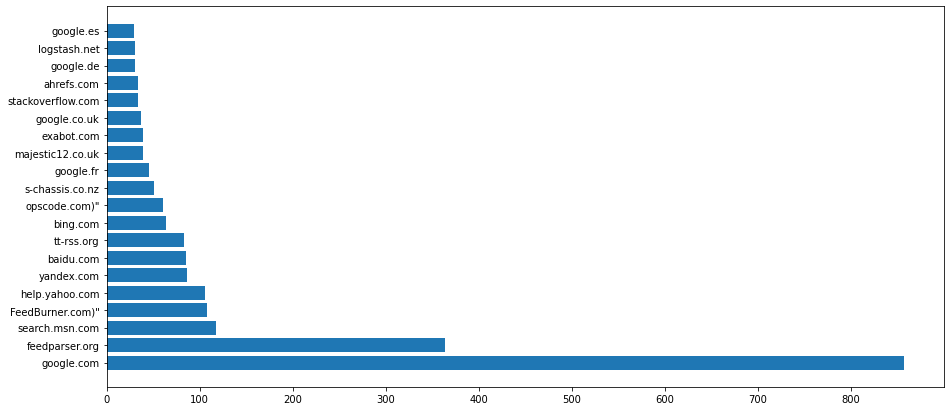

In [27]:
plt.figure(figsize=(15,7))
plt.barh(df['Website'], df['Count'])

# Zad 2

In [28]:
regex = re.compile('\[.+\]')

In [29]:
a = re.search(regex, '83.149.9.216 - - [17/May/2015:10:05:03 +0000] "GET /presentations/logstash-monitorama-2013/images/kibana-search.png HTTP/1.1" 200 203023 "http://semicomplete.com/presentations/logstash-monitorama-2013/" "Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_1) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/32.0.1700.77 Safari/537.36"').group(0)

In [30]:
pd.to_datetime(a[1:].split()[0], format='%d/%b/%Y:%H:%M:%S')

Timestamp('2015-05-17 10:05:03')

In [31]:
def get_time(line):
  regex = re.compile('\[.+\]')
  result = re.search(regex, line).group(0)
  return str(pd.to_datetime(result[1:].split()[0], format='%d/%b/%Y:%H:%M:%S'))

In [32]:
def get_code(line):
  regex = re.compile('HTTP\S+ \d+')
  result = re.search(regex, line).group(0)
  return result.split()[-1]

In [33]:
invokes = lines.map(lambda s: (get_time(s), get_code(s), 1))

In [34]:
df = spark.createDataFrame(invokes, ["Time", "Code", "Count"])

In [35]:
df = df.withColumn('Time', df.Time.cast('timestamp'))

In [36]:
from pyspark.sql import functions as F
from pyspark.sql.window import Window

In [37]:
w = (Window()
     .partitionBy(F.col("Code"))
     .orderBy(F.col("Time").cast('long'))
     .rangeBetween(-3600, 0))

In [38]:
df = df.withColumn('rolling_sum', F.sum("Count").over(w))

In [39]:
df1 = df.toPandas()

In [40]:
df1.set_index('Time', inplace=True)

In [41]:
df1.sort_index(inplace=True)

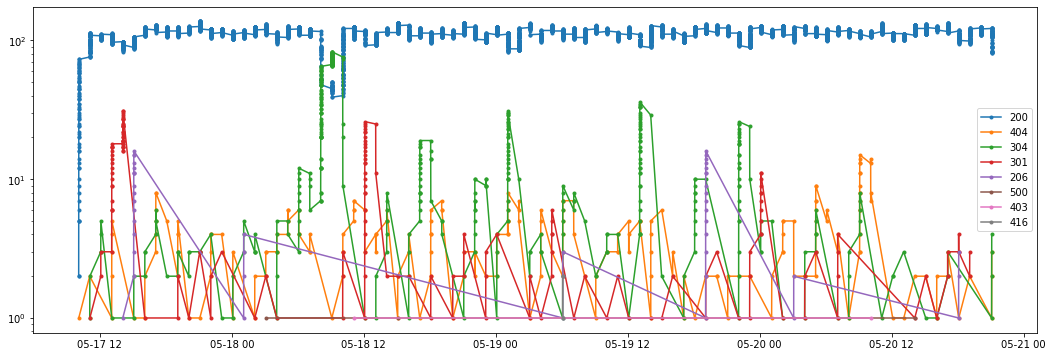

In [42]:
plt.figure(figsize=(18,6))
plt.yscale('log')
for code in df1['Code'].unique():
  plt.plot(df1[df1['Code']==code]['rolling_sum'], '.-', label=code)
plt.legend()
plt.show()

# Zad 3

In [44]:
regex = re.compile('GET (\S)+')

a = re.search(regex, '83.149.9.216 - - [17/May/2015:10:05:03 +0000] "GET /presentations/logstash-monitorama-2013/images/kibana-search.png HTTP/1.1" 200 203023 "http://semicomplete.com/presentations/logstash-monitorama-2013/" "Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_1) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/32.0.1700.77 Safari/537.36"').group(0)

In [45]:
a[a.rfind('.')+1:]

'png'

In [46]:
def get_resource(line):
  regex = re.compile('GET (\S)+')
  result = re.search(regex, line)
  if result is None:
    return None
  result = result.group(0)
  last_dot = result.rfind('.')
  if last_dot == -1:
    return None
  result = result[last_dot+1:]
  return result

In [47]:
resources = lines.map(lambda s: (get_resource(s),1))
resources_filtered = resources.filter(lambda x: x[0] is not None)
resources_count = resources_filtered.reduceByKey(lambda a, b: a + b)

In [48]:
top_resources = resources_count.takeOrdered(20, lambda pair: -pair[1])
top_resources

[('png', 2331),
 ('css', 1458),
 ('ico', 800),
 ('html', 753),
 ('jpg', 257),
 ('js', 250),
 ('txt', 192),
 ('gif', 184),
 ('xhtml', 153),
 ('jar', 90),
 ('com+-+Jordan+Sissel%29', 88),
 ('ttf', 86),
 ('com+-+Jordan+Sissel)', 65),
 ('pdf', 55),
 ('xml', 37),
 ('py', 30),
 ('html?commentlimit=0', 29),
 ('10/', 26),
 ('log', 24),
 ('svg', 22)]

<BarContainer object of 20 artists>

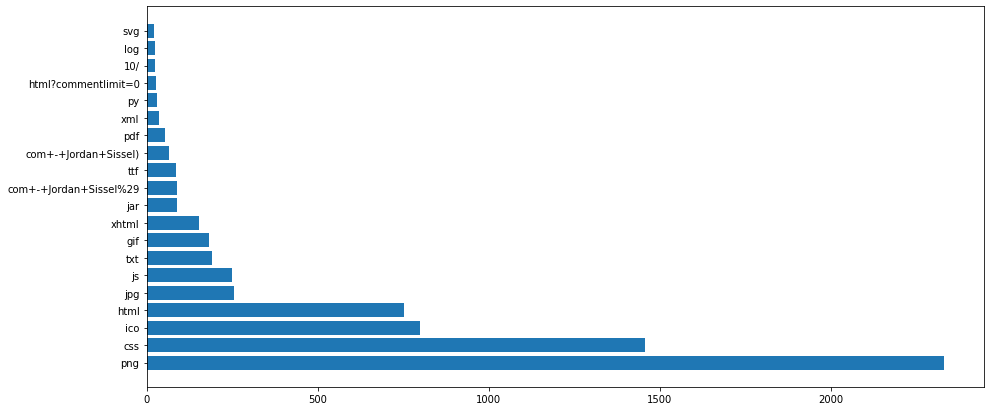

In [49]:
df = pd.DataFrame(top_resources, columns=['Resource', 'Count'])
plt.figure(figsize=(15,7))
plt.barh(df['Resource'], df['Count'])

# Zad 4

In [50]:
regex = '([(\d\.)]+)'
ips = lines.map(lambda s: re.match(regex, s).group(0))

In [51]:
ips = ips.distinct()

In [52]:
import requests
import json


In [53]:
def get_geo(ip):
  request_url = 'https://geolocation-db.com/jsonp/{}'.format(ip)
  response = requests.get(request_url)
  result = response.content.decode()
  result = result.split("(")[1].strip(")")
  result  = json.loads(result)
  return (result['latitude'], result['longitude'])

In [54]:
ips = ips.map(lambda s: get_geo(s))

In [55]:
places = ips.take(50) # dla collect bardzo długo liczy, więc pokazuje na próbce

In [56]:
places = list(filter(lambda a: (a[0] is not None) and (a[1] is not None), places))

In [93]:
# places

In [58]:
pip install https://github.com/matplotlib/basemap/archive/master.zip

     \ 133.1 MB 5.4 MB/s
     |████████████████████████████████| 6.3 MB 7.2 MB/s 
     |████████████████████████████████| 219 kB 42.8 MB/s 
  Created wheel for basemap: filename=basemap-1.2.2+dev-cp37-cp37m-linux_x86_64.whl size=121759608 sha256=74eb418d4caf47fd2317479cb80db403d428aa2ba2425195fa4b3236aaa2a382
  Stored in directory: /tmp/pip-ephem-wheel-cache-5w_qtx5w/wheels/98/1a/9d/de6aa4dee52d726996be77bb4a65cf03865288bfc35e5b24d8
  Created wheel for pyshp: filename=pyshp-2.1.3-py3-none-any.whl size=37325 sha256=a9e2b4a477422a48ccf10a938ca1f08eb340c4989bac927a74c9f853c4e5111b
  Stored in directory: /root/.cache/pip/wheels/43/f8/87/53c8cd41545ba20e536ea29a8fcb5431b5f477ca50d5dffbbe
Successfully built basemap pyshp


In [59]:
from mpl_toolkits.basemap import Basemap
import numpy as np

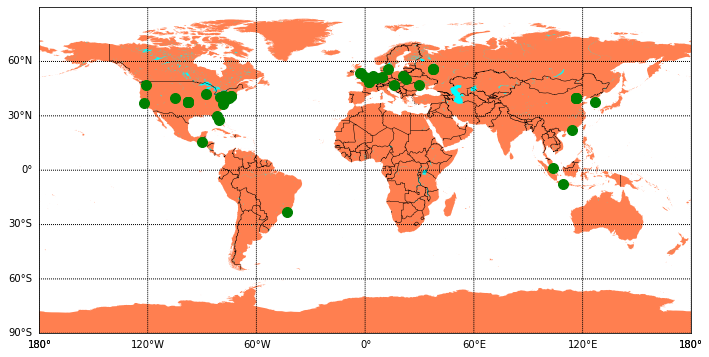

In [92]:
latitudes = [x[1] for x in places]
longitudes =  [x[0] for x in places]


plt.figure(figsize=(12, 6))
my_map = Basemap( resolution = 'l', area_thresh = 10.0,
              lat_0=0, lon_0=0)
something = my_map.scatter(latitudes, longitudes, latlon=True, marker='o', color='g', s=14, zorder=20)
my_map.drawparallels(np.arange(-90,90,30),labels=[1,0,0,0])
my_map.drawmeridians(np.arange(my_map.lonmin,my_map.lonmax,60),labels=[0,0,0,1])
my_map.fillcontinents(color='coral',lake_color='aqua')
my_map.drawcountries()
x,y = my_map(latitudes, longitudes)
my_map.plot(x, y, 'go', markersize=10)

plt.show()


# Zad 5

(Zakładam filter na IP botów: jeśli zdarzyło się wygenerować więcej niż 60 zapytań w ciągu minuty)

In [94]:
def get_time(line):
  regex = re.compile('\[.+\]')
  result = re.search(regex, line).group(0)
  return str(pd.to_datetime(result[1:].split()[0], format='%d/%b/%Y:%H:%M:%S'))

In [95]:
regex = '([(\d\.)]+)'

In [96]:
invokes_ip = lines.map(lambda s: (get_time(s), re.match(regex, s).group(0), 1))

In [97]:
df = spark.createDataFrame(invokes_ip, ["Time", "IP", "Count"])
df = df.withColumn('Time', df.Time.cast('timestamp'))

In [98]:
w = (Window()
     .partitionBy(F.col("IP"))
     .orderBy(F.col("Time").cast('long'))
     .rangeBetween(-60, 0))

In [99]:
df = df.withColumn('rolling_sum', F.sum("Count").over(w))

In [100]:
df1 = df.groupBy('IP').agg(F.max('rolling_sum'))

In [101]:
df1 = df1.filter("max(rolling_sum) >60")

In [102]:
df1 = df1.select('IP').distinct().collect()

In [103]:
bots = [a['IP'] for a in df1]

In [104]:
bot_invokes = df.filter(df.IP.isin(bots)).count()

In [105]:
all_invokes = df.count()

In [106]:
print(bot_invokes/all_invokes)

0.063
